In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For spatial analysis
import pysal.lib as ps
from pysal.explore import esda


c:\Users\craigparker\Anaconda3\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
# Load the GeoJSON file using GeoPandas
file_path = 'HVI_with_columnames.geojson'  # Replace with your actual file path
gdf = gpd.read_file(file_path)

# Explode multi-part geometries into single-part geometries if necessary
gdf = gdf.explode(index_parts=False)

# Display the first few rows
gdf.head()


,OBJECTID_,WardID_,WardNo_,Crowded dwellings,No piped water,Using public healthcare facilities,Poor health status,Failed to find healthcare when needed,No medical insurance,Household hunger risk,...,tb_prop,covid_prop,60_plus_pr,Ward_HVI_1_OBJECTID_,Ward_HVI_1_WardNo_,Ward_HVI_1_HVI_PC1,Ward_HVI_1_HVI_weighted,Ward_HVI_1_HVI_PC1_standardized,Ward_HVI_1_HVI_weighted_standardized,geometry
0,3692,74205010,10,11.78,0.00,91.69,6.34,2.54,88.02,36.35,...,0.000500,0.000500,0.000500,3692,10,-1.0675894606842515,-0.06203826320367767,0.3329997012335213,0.4391669315792239,"POLYGON ((27.71776 -26.20286, 27.72029 -26.203..."
1,2390,79800001,1,13.43,1.63,83.82,5.64,10.54,83.44,50.33,...,0.000000,0.000385,0.000385,2390,1,-2.569987902460258,-0.761630731739387,0.1832694286792885,0.24883308624603795,"POLYGON ((27.85069 -26.47809, 27.85306 -26.480..."
2,2391,79800002,2,37.54,0.00,88.13,5.20,5.57,85.63,70.01,...,0.000000,0.000000,0.000385,2391,2,-3.1743817739259828,-0.8892171999460734,0.12303503506683623,0.21412141595449397,"POLYGON ((27.88297 -26.49297, 27.88653 -26.507..."
3,2392,79800003,3,16.03,1.58,90.00,0.00,7.41,56.14,50.54,...,0.000385,0.000000,0.000385,2392,3,-1.646309337963577,-0.48064443181817873,0.2753239991373762,0.32527931080572614,"POLYGON ((27.87042 -26.46787, 27.87073 -26.475..."
4,2393,79800004,4,13.77,0.00,84.38,4.64,0.00,64.37,56.42,...,0.000000,0.000000,0.000769,2393,4,-1.1988285890961565,-0.4033934750373366,0.31992030104214103,0.34629650627459774,"POLYGON ((27.86907 -26.44480, 27.87042 -26.467..."


In [3]:
variables = [
    'Crowded dwellings', 'No piped water', 'Using public healthcare facilities', 'Poor health status',
    'Failed to find healthcare when needed', 'No medical insurance', 'Household hunger risk',
    'Benefiting from school feeding scheme', 'UTFVI', 'LST', 'NDVI', 'NDBI__mean', 'concern_he',
    'cancer_pro', 'diabetes_p', 'pneumonia_', 'heart_dise', 'hypertensi', 'hiv_prop', 'tb_prop',
    'covid_prop', '60_plus_pr'
]

# Check for missing values
missing_values = gdf[variables].isnull().sum()
print("Missing values in each variable:")
print(missing_values)


Missing values in each variable:
Crowded dwellings                        0
No piped water                           0
Using public healthcare facilities       0
Poor health status                       0
Failed to find healthcare when needed    0
No medical insurance                     0
Household hunger risk                    0
Benefiting from school feeding scheme    0
UTFVI                                    0
LST                                      0
NDVI                                     0
NDBI__mean                               0
concern_he                               0
cancer_pro                               0
diabetes_p                               0
pneumonia_                               0
heart_dise                               0
hypertensi                               0
hiv_prop                                 0
tb_prop                                  0
covid_prop                               0
60_plus_pr                               0
dtype: int64


In [4]:
# Convert variables to numeric if necessary
for var in variables:
    gdf[var] = pd.to_numeric(gdf[var], errors='coerce')

# Re-check for missing values after conversion
missing_values = gdf[variables].isnull().sum()
print("Missing values after type conversion:")
print(missing_values)


Missing values after type conversion:
Crowded dwellings                        0
No piped water                           0
Using public healthcare facilities       0
Poor health status                       0
Failed to find healthcare when needed    0
No medical insurance                     0
Household hunger risk                    0
Benefiting from school feeding scheme    0
UTFVI                                    0
LST                                      0
NDVI                                     0
NDBI__mean                               0
concern_he                               0
cancer_pro                               0
diabetes_p                               0
pneumonia_                               0
heart_dise                               0
hypertensi                               0
hiv_prop                                 0
tb_prop                                  0
covid_prop                               0
60_plus_pr                               0
dtype: int64


In [6]:
# For simplicity, drop rows with missing values
gdf_clean = gdf.dropna(subset=variables).copy()
print(f"Number of rows after dropping missing values: {gdf_clean.shape[0]}")


Number of rows after dropping missing values: 135


In [7]:
# Descriptive statistics of the variables
desc_stats = gdf_clean[variables].describe()
print(desc_stats)

# Save the descriptive statistics to a CSV file
desc_stats.to_csv('Descriptive_Statistics.csv')


       Crowded dwellings  No piped water  Using public healthcare facilities  \
count         135.000000      135.000000                          135.000000   
mean           15.188667        5.449333                           61.922593   
std            11.970417        9.447985                           30.486634   
min             0.000000        0.000000                            3.560000   
25%             3.260000        0.000000                           31.580000   
50%            15.010000        1.980000                           73.690000   
75%            23.875000        5.665000                           87.030000   
max            51.520000       62.950000                           98.550000   

       Poor health status  Failed to find healthcare when needed  \
count           135.00000                             135.000000   
mean              7.17763                               4.204667   
std               4.48167                               3.267116   
min    

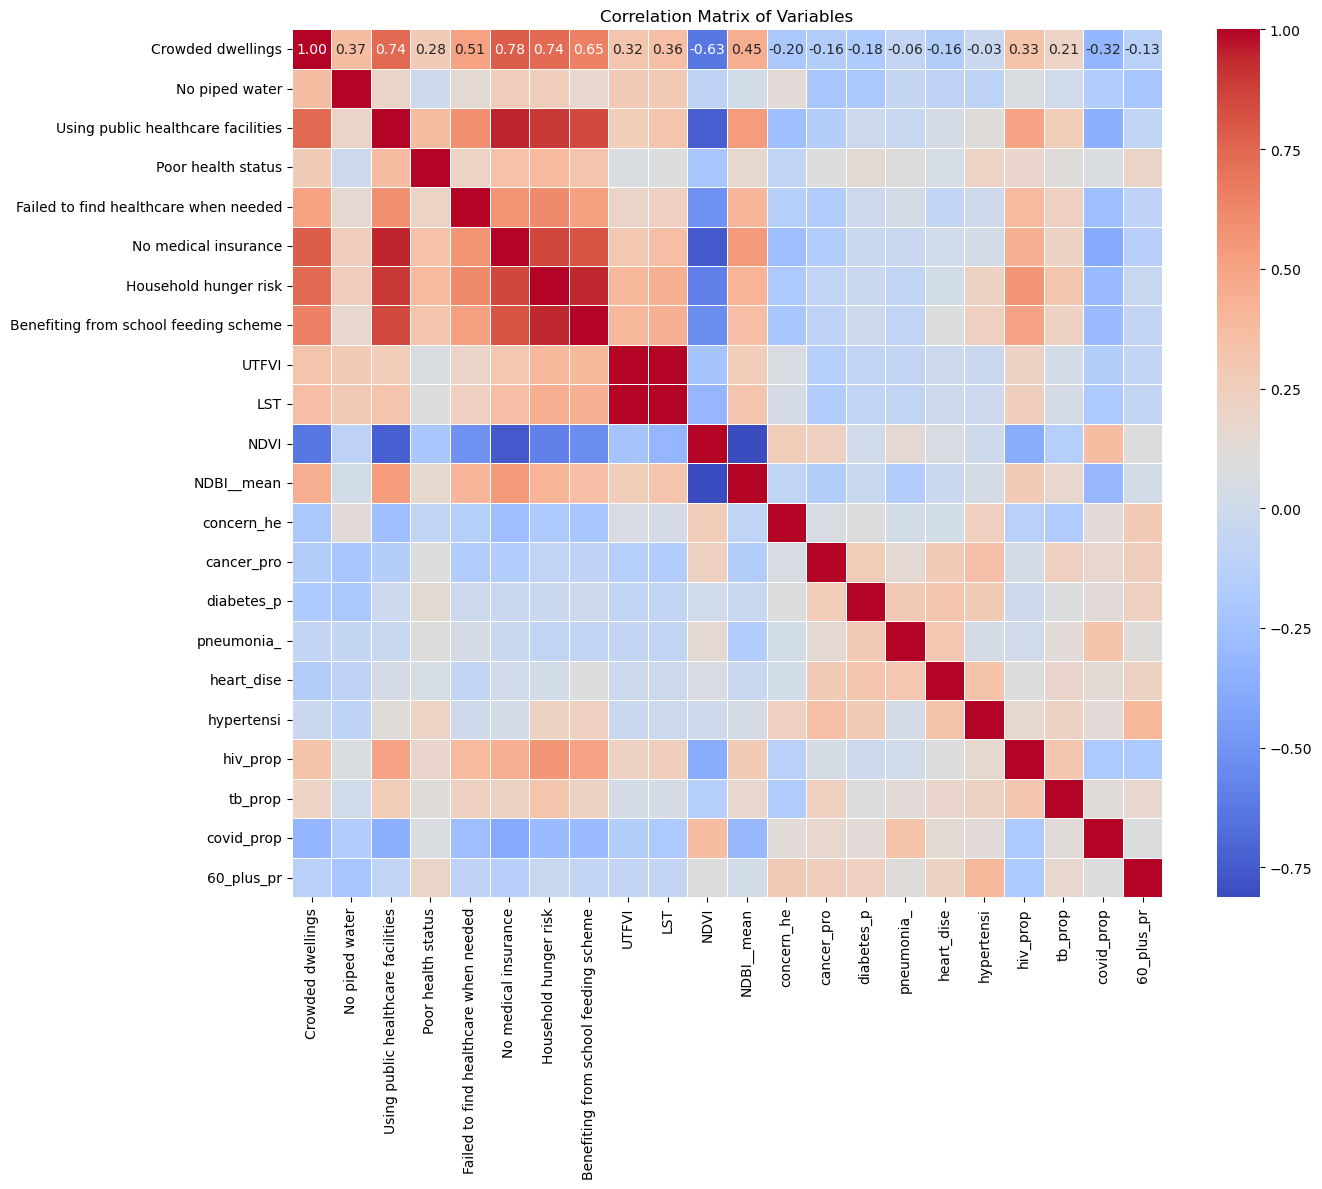

In [8]:
# Compute the correlation matrix
corr_matrix = gdf_clean[variables].corr()

# Visualize the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Variables')
plt.tight_layout()
plt.show()

# Save the correlation matrix
corr_matrix.to_csv('Correlation_Matrix.csv')


In [9]:
# Standardize the variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(gdf_clean[variables])


In [10]:
# Initialize PCA
pca = PCA(n_components=None)
principal_components = pca.fit_transform(scaled_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Determine the number of components explaining 90% variance
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components explaining 90% variance: {n_components}")


Number of components explaining 90% variance: 13


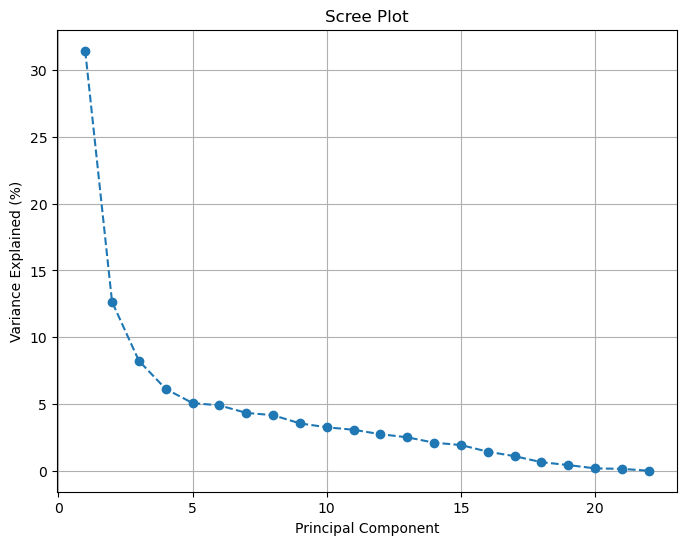

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance * 100, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.grid(True)
plt.show()


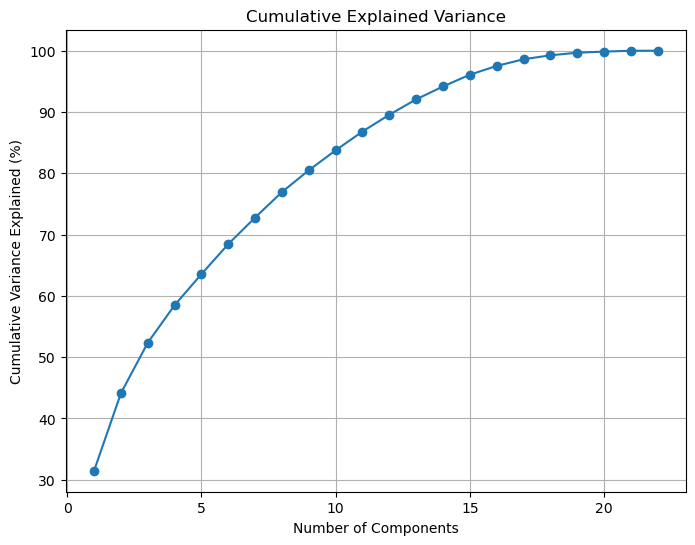

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.grid(True)
plt.show()


In [13]:
# Get the loadings (coefficients)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(explained_variance))], index=variables)

# Display the loadings for the first three principal components
loadings_first_three = loadings[['PC1', 'PC2', 'PC3']]
print(loadings_first_three)


                                            PC1       PC2       PC3
Crowded dwellings                     -0.310918 -0.056326  0.042989
No piped water                        -0.112483 -0.191059 -0.256855
Using public healthcare facilities    -0.352105  0.076542  0.123018
Poor health status                    -0.132356  0.230866  0.032982
Failed to find healthcare when needed -0.256746  0.016471  0.106190
No medical insurance                  -0.351050  0.026580  0.109180
Household hunger risk                 -0.349229  0.106490 -0.022795
Benefiting from school feeding scheme -0.326710  0.106338 -0.034114
UTFVI                                 -0.181751 -0.107997 -0.580553
LST                                   -0.205122 -0.105668 -0.552797
NDVI                                   0.300604  0.033316 -0.167401
NDBI__mean                            -0.240871 -0.017188  0.069503
concern_he                             0.098298  0.061004 -0.391323
cancer_pro                             0.077956 

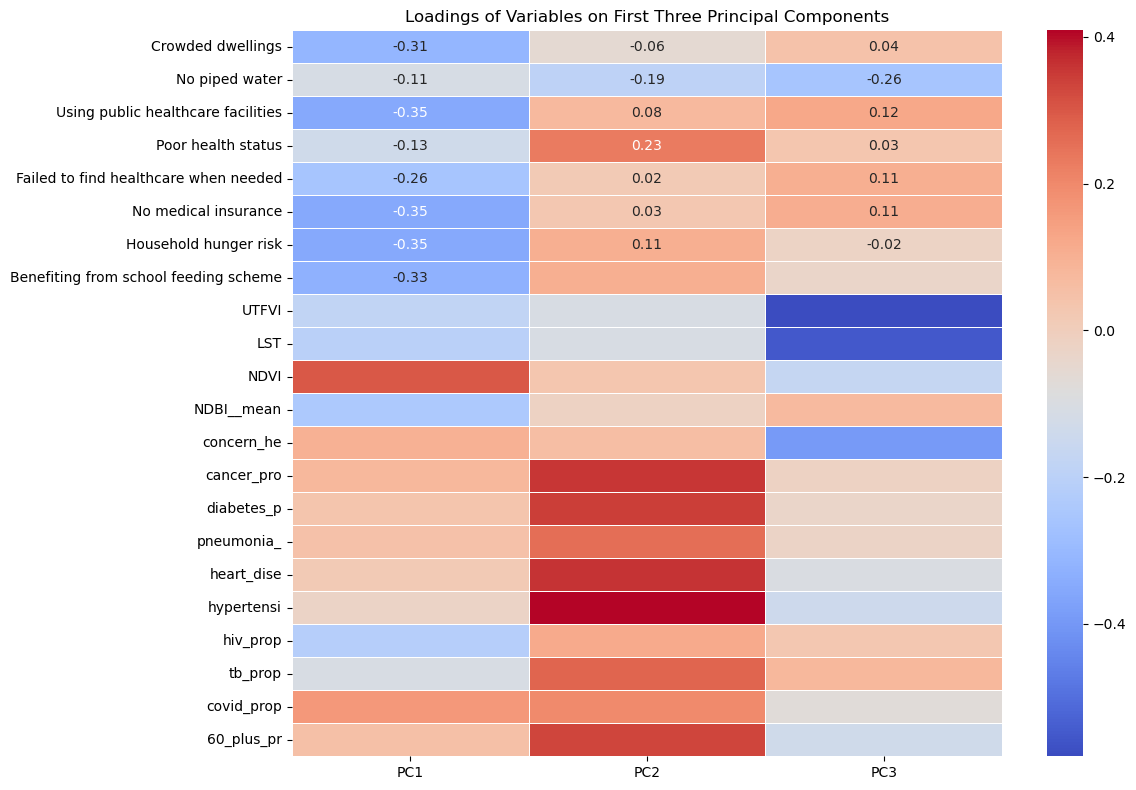

In [14]:
# Heatmap of loadings for the first three PCs
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_first_three, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Loadings of Variables on First Three Principal Components')
plt.tight_layout()
plt.show()


In [15]:
# Add PC1 to the GeoDataFrame
gdf_clean['HVI_PC1'] = principal_components[:, 0]

# Standardize HVI_PC1
gdf_clean['HVI_PC1_standardized'] = (gdf_clean['HVI_PC1'] - gdf_clean['HVI_PC1'].min()) / (gdf_clean['HVI_PC1'].max() - gdf_clean['HVI_PC1'].min())


In [16]:
# Use the first n_components that explain 90% variance
weights = explained_variance[:n_components]
gdf_clean['HVI_weighted'] = principal_components[:, :n_components] @ weights

# Standardize the weighted HVI
gdf_clean['HVI_weighted_standardized'] = (gdf_clean['HVI_weighted'] - gdf_clean['HVI_weighted'].min()) / (gdf_clean['HVI_weighted'].max() - gdf_clean['HVI_weighted'].min())


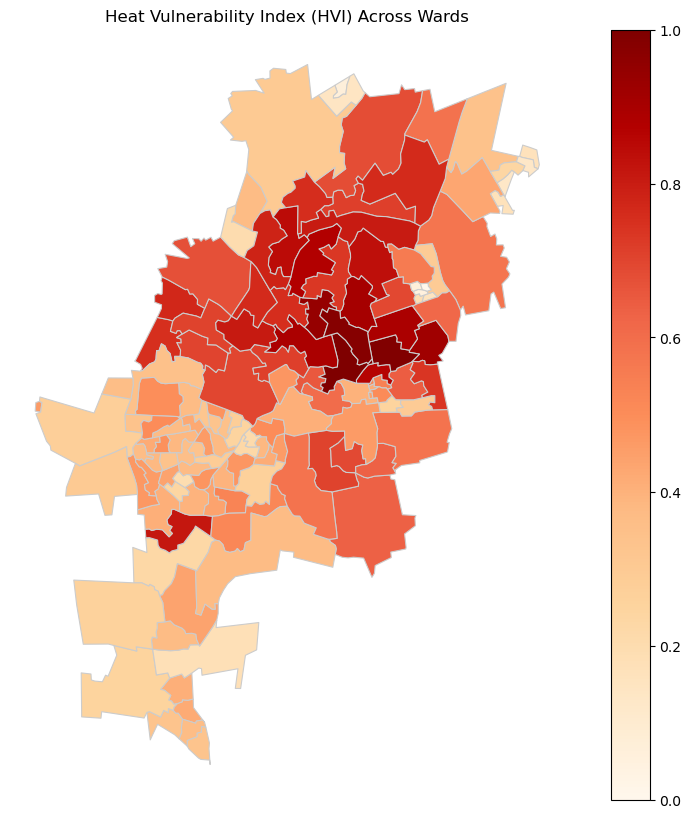

In [17]:
# Plot HVI across wards
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.plot(column='HVI_weighted_standardized', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Heat Vulnerability Index (HVI) Across Wards')
ax.set_axis_off()
plt.show()


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_32324\1639456632.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


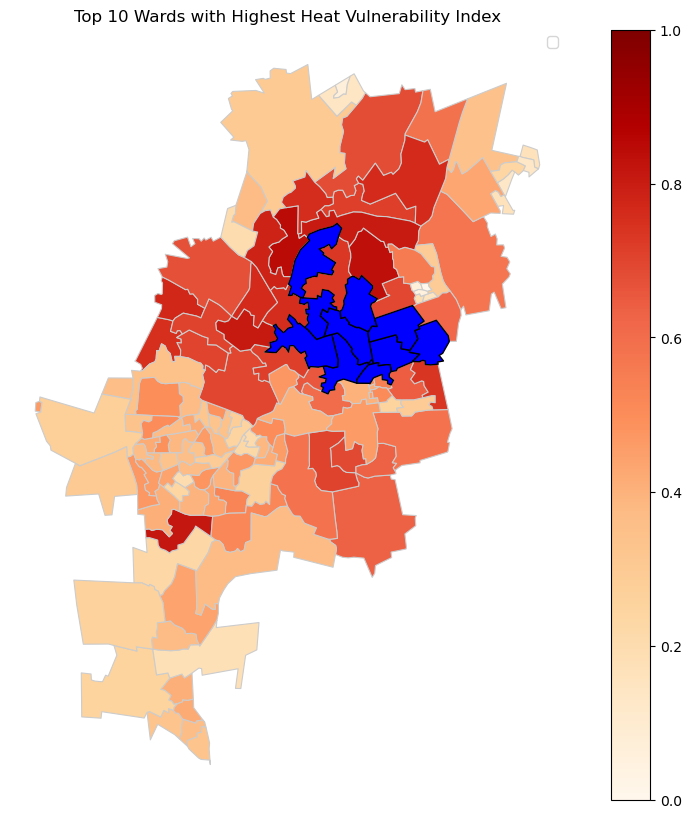

Top 10 Vulnerable Wards:
      WardID_  HVI_weighted_standardized
86   79800087                   1.000000
73   79800073                   0.995599
116  79800117                   0.984097
98   79800099                   0.944253
72   79800072                   0.921102
89   79800090                   0.905557
74   79800074                   0.893363
87   79800088                   0.892488
103  79800104                   0.876396
67   79800067                   0.865001


In [18]:
# Identify top 10 vulnerable wards
top_10_wards = gdf_clean.nlargest(10, 'HVI_weighted_standardized')

# Plot the map with top 10 wards highlighted
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.plot(column='HVI_weighted_standardized', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
top_10_wards.plot(ax=ax, color='blue', edgecolor='black', linewidth=1, label='Top 10 Vulnerable Wards')
plt.title('Top 10 Wards with Highest Heat Vulnerability Index')
ax.set_axis_off()
plt.legend()
plt.show()

# Display top 10 wards
print("Top 10 Vulnerable Wards:")
print(top_10_wards[['WardID_', 'HVI_weighted_standardized']])


In [19]:
# Climate variables
climate_vars = ['UTFVI', 'LST', 'NDVI', 'NDBI__mean']

# Socio-economic variables
socio_econ_vars = [
    'Crowded dwellings', 'No piped water', 'Using public healthcare facilities',
    'Poor health status', 'Failed to find healthcare when needed', 'No medical insurance',
    'Household hunger risk', 'Benefiting from school feeding scheme', 'diabetes_p',
    'heart_dise', 'hypertensi', 'hiv_prop', 'tb_prop', 'covid_prop', '60_plus_pr'
]


In [20]:
# Climate PCA
scaled_climate = scaler.fit_transform(gdf_clean[climate_vars])
pca_climate = PCA(n_components=None)
pc_climate = pca_climate.fit_transform(scaled_climate)
gdf_clean['Climate_PC1'] = pc_climate[:, 0]

# Socio-economic PCA
scaled_socioecon = scaler.fit_transform(gdf_clean[socio_econ_vars])
pca_socioecon = PCA(n_components=None)
pc_socioecon = pca_socioecon.fit_transform(scaled_socioecon)
gdf_clean['SocioEcon_PC1'] = pc_socioecon[:, 0]


In [21]:
# Correlation between Climate_PC1 and SocioEcon_PC1
correlation_pc1 = gdf_clean['Climate_PC1'].corr(gdf_clean['SocioEcon_PC1'])
print(f"Correlation between Climate_PC1 and SocioEcon_PC1: {correlation_pc1:.2f}")


Correlation between Climate_PC1 and SocioEcon_PC1: -0.61


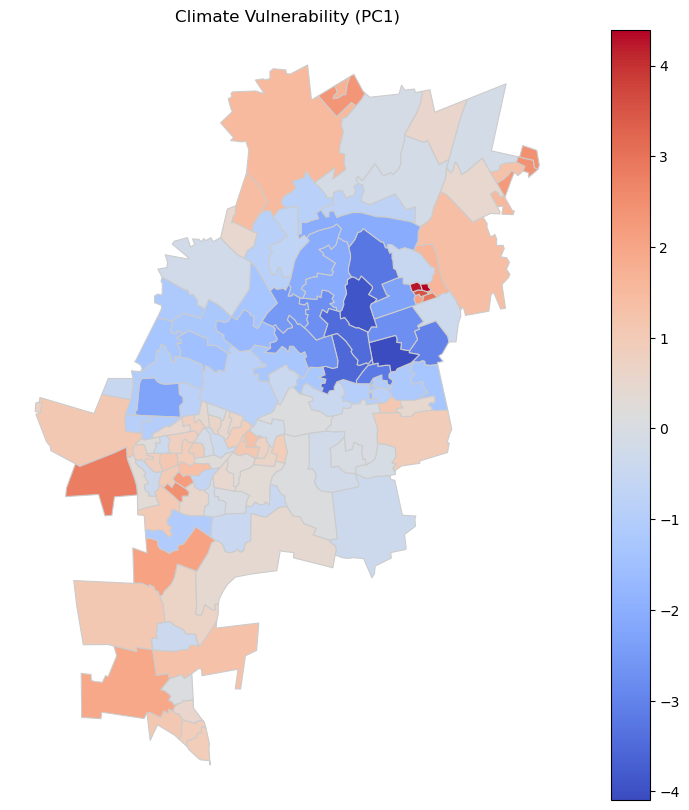

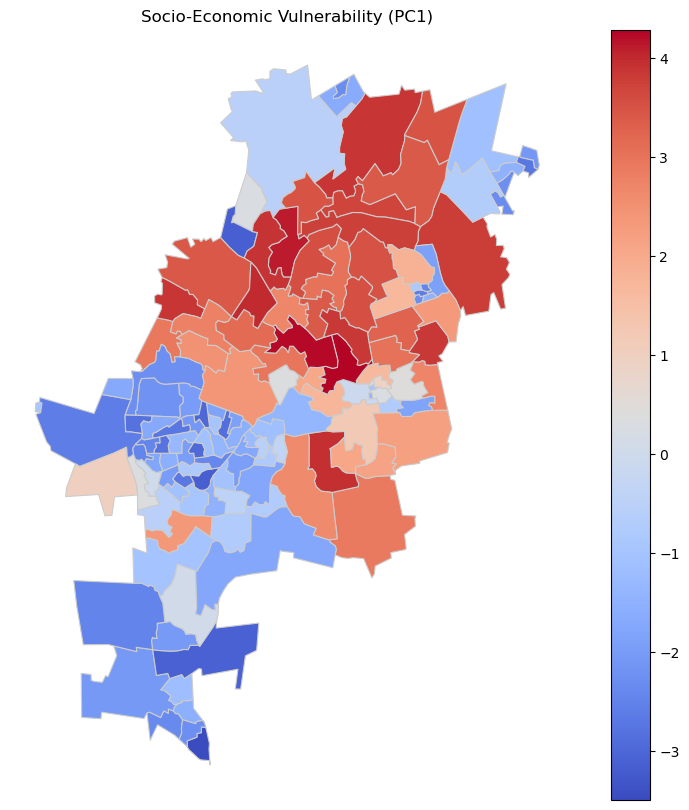

In [22]:
# Map of Climate_PC1
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.plot(column='Climate_PC1', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Climate Vulnerability (PC1)')
ax.set_axis_off()
plt.show()

# Map of SocioEcon_PC1
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.plot(column='SocioEcon_PC1', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Socio-Economic Vulnerability (PC1)')
ax.set_axis_off()
plt.show()


In [24]:
# For Climate PCA loadings
# Select the first three components
loadings_climate = pd.DataFrame(pca_climate.components_[:3].T, columns=['Climate_PC1', 'Climate_PC2', 'Climate_PC3'], index=climate_vars)

# For Socio-Economic PCA loadings
# Select the first three components
loadings_socioecon = pd.DataFrame(pca_socioecon.components_[:3].T, columns=['SocioEcon_PC1', 'SocioEcon_PC2', 'SocioEcon_PC3'], index=socio_econ_vars)

# Now, proceed to get the top contributing variables
climate_pc1_loadings = loadings_climate['Climate_PC1'].abs().sort_values(ascending=False)
print("Top variables contributing to Climate_PC1:")
print(climate_pc1_loadings)

socioecon_pc1_loadings = loadings_socioecon['SocioEcon_PC1'].abs().sort_values(ascending=False)
print("\nTop variables contributing to SocioEcon_PC1:")
print(socioecon_pc1_loadings)



Top variables contributing to Climate_PC1:
LST           0.552341
UTFVI         0.524600
NDBI__mean    0.463086
NDVI          0.453064
Name: Climate_PC1, dtype: float64

Top variables contributing to SocioEcon_PC1:
Household hunger risk                    0.406775
Using public healthcare facilities       0.402326
No medical insurance                     0.394904
Benefiting from school feeding scheme    0.380815
Crowded dwellings                        0.347791
Failed to find healthcare when needed    0.292780
hiv_prop                                 0.256247
Poor health status                       0.169563
covid_prop                               0.168576
tb_prop                                  0.140438
No piped water                           0.126365
hypertensi                               0.060213
60_plus_pr                               0.046857
diabetes_p                               0.025914
heart_dise                               0.002182
Name: SocioEcon_PC1, dtype: float64

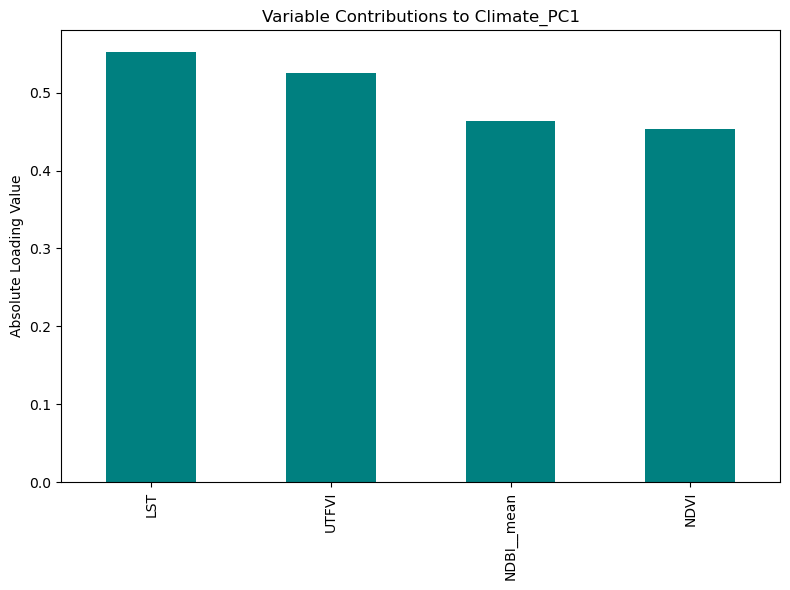

In [25]:
# Plot for Climate_PC1
plt.figure(figsize=(8, 6))
climate_pc1_loadings.plot(kind='bar', color='teal')
plt.title('Variable Contributions to Climate_PC1')
plt.ylabel('Absolute Loading Value')
plt.tight_layout()
plt.show()


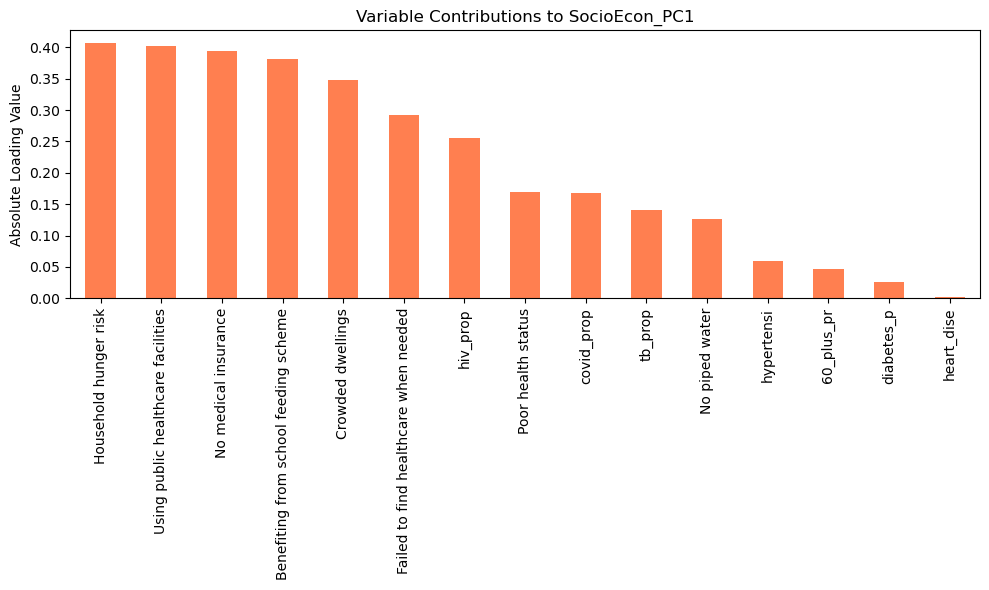

In [26]:
# Plot for SocioEcon_PC1
plt.figure(figsize=(10, 6))
socioecon_pc1_loadings.plot(kind='bar', color='coral')
plt.title('Variable Contributions to SocioEcon_PC1')
plt.ylabel('Absolute Loading Value')
plt.tight_layout()
plt.show()


In [27]:
interaction_vars = ['LST', 'NDVI', 'Poor health status', 'Household hunger risk', 'No medical insurance']
interaction_data = gdf_clean[interaction_vars]


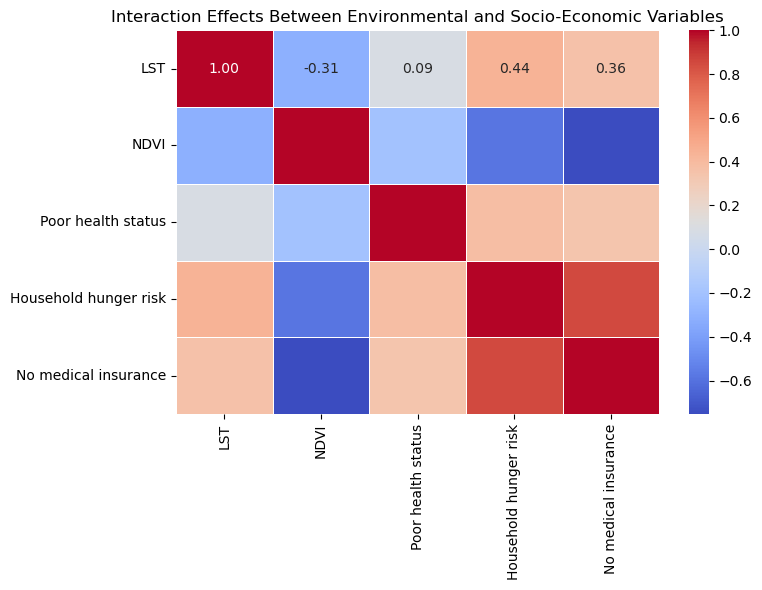

In [28]:
# Compute correlation matrix
interaction_corr = interaction_data.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(interaction_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Interaction Effects Between Environmental and Socio-Economic Variables')
plt.tight_layout()
plt.show()


In [29]:
# Create spatial weights using Queen contiguity
weights = ps.weights.contiguity.Queen.from_dataframe(gdf_clean)
weights.transform = 'r'  # Row-standardized weights


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_32324\244498597.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = ps.weights.contiguity.Queen.from_dataframe(gdf_clean)


In [31]:
# Moran's I for HVI
moran_hvi = esda.Moran(gdf_clean['HVI_weighted_standardized'], weights)
print(f"Moran's I for HVI: {moran_hvi.I:.4f}, p-value: {moran_hvi.p_sim:.4f}")


Moran's I for HVI: 0.6226, p-value: 0.0010


In [32]:
# Local Moran's I
lisa = esda.Moran_Local(gdf_clean['HVI_weighted_standardized'], weights)

# Add LISA cluster labels to the GeoDataFrame
gdf_clean['LISA_Cluster'] = lisa.q

# Define cluster labels
cluster_labels = {
    1: 'HH',
    2: 'LH',
    3: 'LL',
    4: 'HL'
}
gdf_clean['LISA_Type'] = gdf_clean['LISA_Cluster'].map(cluster_labels)


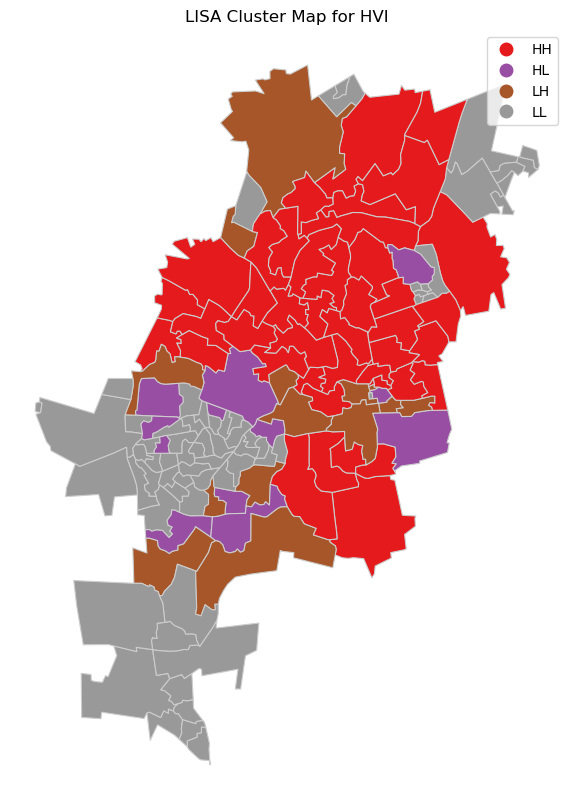

In [33]:
# Plot LISA cluster map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.plot(column='LISA_Type', categorical=True, legend=True, cmap='Set1', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.title('LISA Cluster Map for HVI')
ax.set_axis_off()
plt.show()


In [34]:
# Using the first three principal components and their explained variance ratios
weights_total = explained_variance[:3]
gdf_clean['CVI'] = principal_components[:, :3] @ weights_total

# Standardize CVI
gdf_clean['CVI_standardized'] = (gdf_clean['CVI'] - gdf_clean['CVI'].min()) / (gdf_clean['CVI'].max() - gdf_clean['CVI'].min())


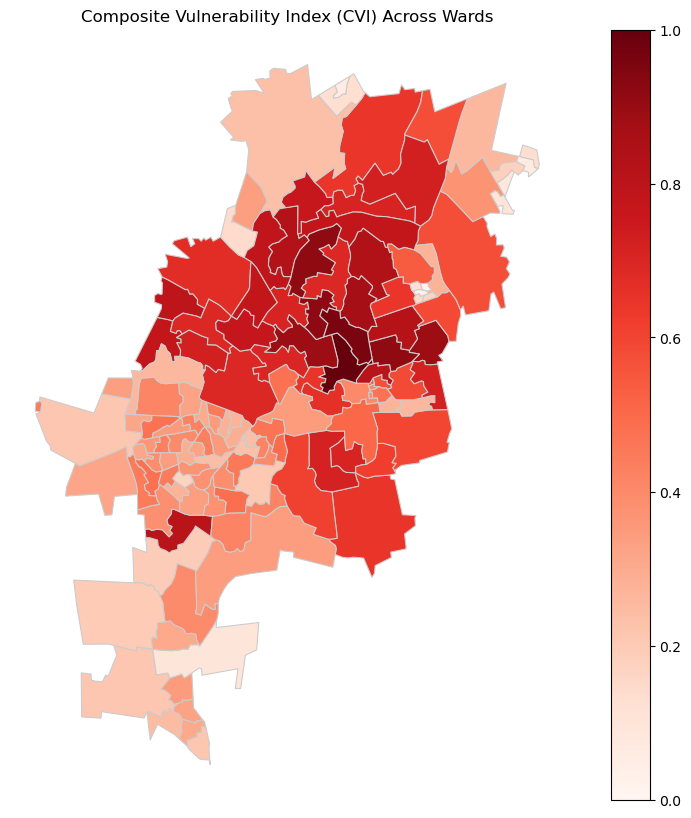

In [35]:
# Map of CVI
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.plot(column='CVI_standardized', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Composite Vulnerability Index (CVI) Across Wards')
ax.set_axis_off()
plt.show()


In [36]:
# Save the GeoDataFrame with computed indices
gdf_clean.to_file('HVI_with_CVI.geojson', driver='GeoJSON')
gdf_clean.to_csv('HVI_with_CVI.csv', index=False)


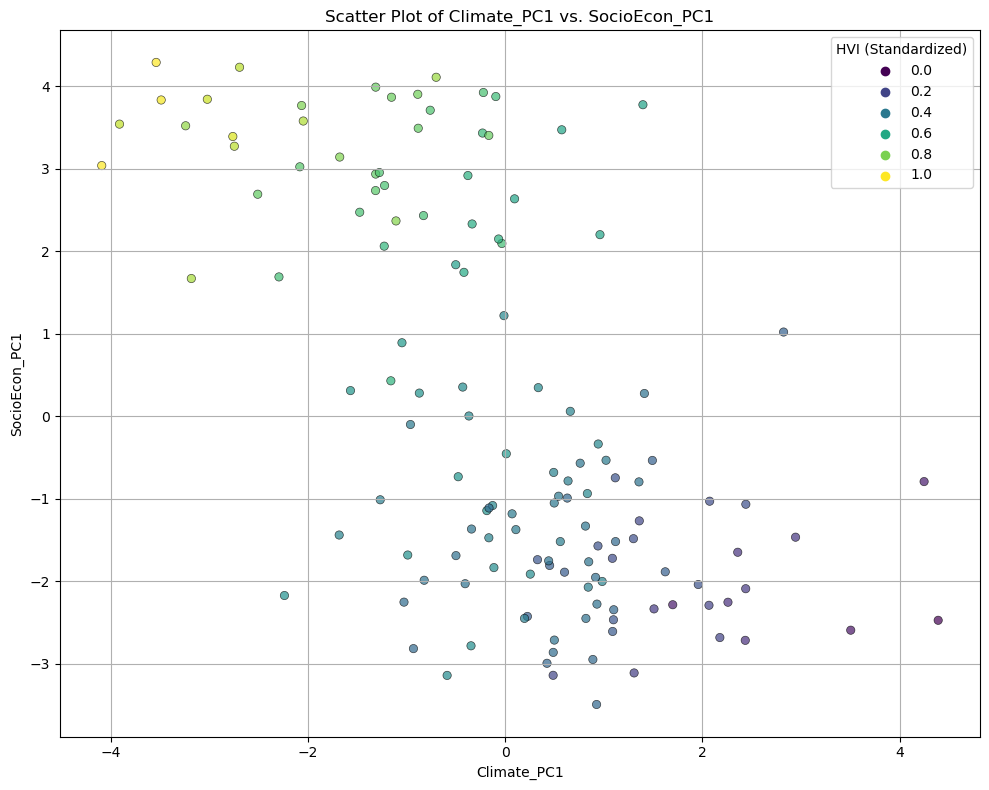

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Climate_PC1',
    y='SocioEcon_PC1',
    data=gdf_clean,
    hue='HVI_weighted_standardized',
    palette='viridis',
    edgecolor='k',
    alpha=0.7
)
plt.title('Scatter Plot of Climate_PC1 vs. SocioEcon_PC1')
plt.xlabel('Climate_PC1')
plt.ylabel('SocioEcon_PC1')
plt.legend(title='HVI (Standardized)')
plt.grid(True)
plt.tight_layout()
plt.show()


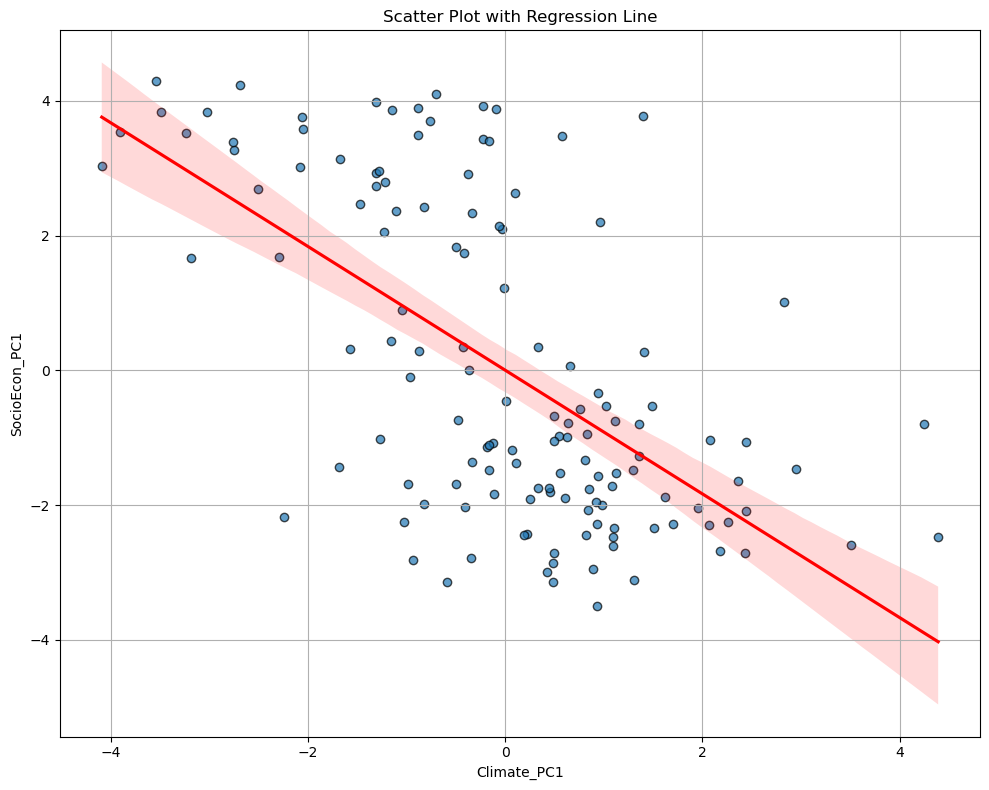

In [38]:
# Scatter plot with regression line
plt.figure(figsize=(10, 8))
sns.regplot(
    x='Climate_PC1',
    y='SocioEcon_PC1',
    data=gdf_clean,
    scatter_kws={'alpha':0.7, 'edgecolor':'k'},
    line_kws={'color':'red'}
)
plt.title('Scatter Plot with Regression Line')
plt.xlabel('Climate_PC1')
plt.ylabel('SocioEcon_PC1')
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient and p-value
corr_coef, p_value = pearsonr(gdf_clean['Climate_PC1'], gdf_clean['SocioEcon_PC1'])
print(f"Pearson correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_value:.4f}")


Pearson correlation coefficient: -0.6134
P-value: 0.0000


In [40]:
import statsmodels.api as sm

# Prepare data
X = gdf_clean['Climate_PC1']
y = gdf_clean['SocioEcon_PC1']

# Add constant term for intercept
X_const = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X_const).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          SocioEcon_PC1   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     80.22
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           2.60e-15
Time:                        13:47:56   Log-Likelihood:                -275.10
No. Observations:                 135   AIC:                             554.2
Df Residuals:                     133   BIC:                             560.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.388e-17      0.161   8.62e-17      

In [41]:
# Calculate median values of PCs
climate_median = gdf_clean['Climate_PC1'].median()
socioecon_median = gdf_clean['SocioEcon_PC1'].median()

# Function to categorize wards
def categorize_ward(row):
    if row['Climate_PC1'] >= climate_median and row['SocioEcon_PC1'] >= socioecon_median:
        return 'High Climate, High SocioEcon'
    elif row['Climate_PC1'] >= climate_median and row['SocioEcon_PC1'] < socioecon_median:
        return 'High Climate, Low SocioEcon'
    elif row['Climate_PC1'] < climate_median and row['SocioEcon_PC1'] >= socioecon_median:
        return 'Low Climate, High SocioEcon'
    else:
        return 'Low Climate, Low SocioEcon'

# Apply categorization
gdf_clean['Ward_Category'] = gdf_clean.apply(categorize_ward, axis=1)

# Count of wards in each category
print(gdf_clean['Ward_Category'].value_counts())


Ward_Category
High Climate, Low SocioEcon     50
Low Climate, High SocioEcon     50
High Climate, High SocioEcon    18
Low Climate, Low SocioEcon      17
Name: count, dtype: int64


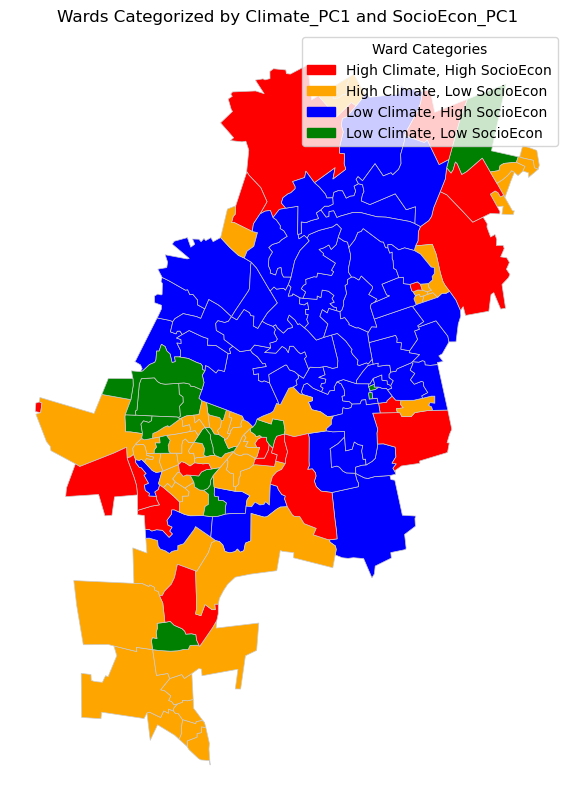

In [43]:
from matplotlib.colors import ListedColormap



# Define color mapping
category_colors = {
    'High Climate, High SocioEcon': 'red',
    'High Climate, Low SocioEcon': 'orange',
    'Low Climate, High SocioEcon': 'blue',
    'Low Climate, Low SocioEcon': 'green'
}

# Plot map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.plot(
    column='Ward_Category',
    categorical=True,
    cmap=ListedColormap([category_colors[x] for x in category_colors.keys()]),
    legend=True,
    linewidth=0.5,
    ax=ax,
    edgecolor='0.8'
)

# Customize legend
handles = [plt.Rectangle((0,0),1,1, color=category_colors[label]) for label in category_colors]
labels = category_colors.keys()
ax.legend(handles, labels, title='Ward Categories')

plt.title('Wards Categorized by Climate_PC1 and SocioEcon_PC1')
ax.set_axis_off()
plt.show()


c:\Users\craigparker\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\craigparker\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\craigparker\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\craigparker\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it 

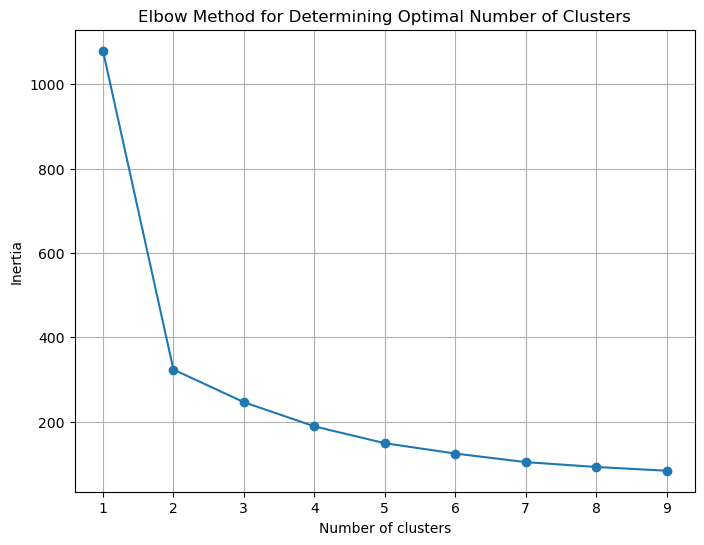

In [44]:
from sklearn.cluster import KMeans
import numpy as np

# Select the PC scores for clustering
X_cluster = gdf_clean[['Climate_PC1', 'SocioEcon_PC1']]

# Determine optimal number of clusters using Elbow Method
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


c:\Users\craigparker\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\craigparker\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


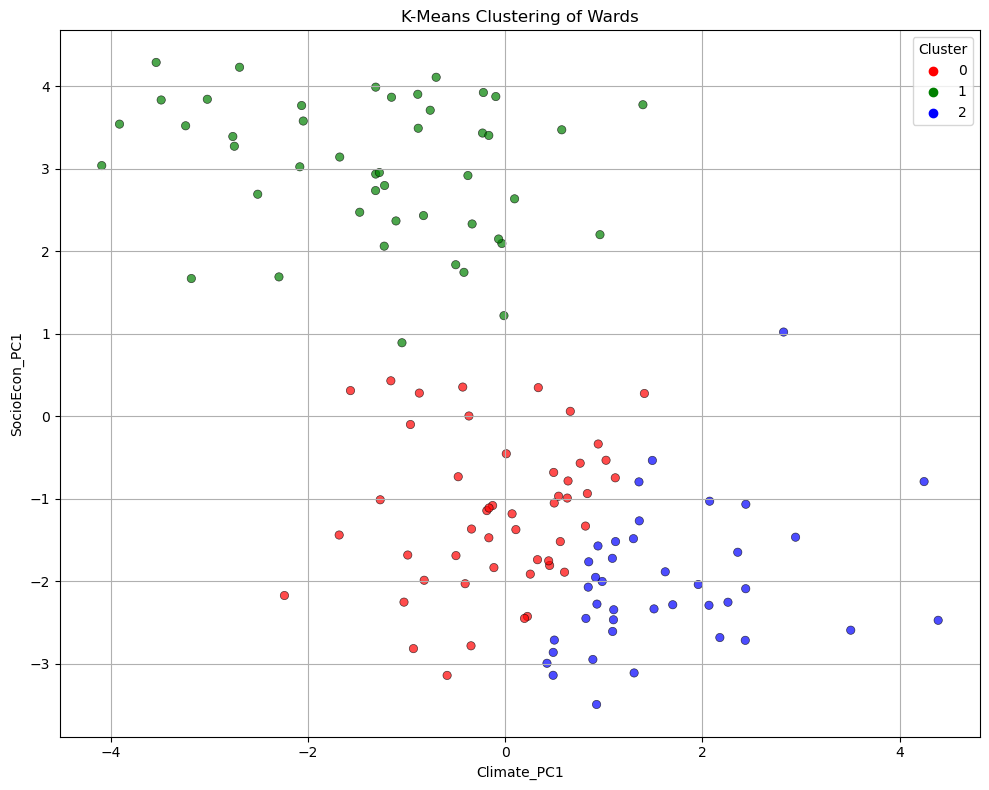

In [45]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
gdf_clean['Cluster'] = kmeans.fit_predict(X_cluster)

# Map cluster labels to colors
cluster_colors = {0: 'red', 1: 'green', 2: 'blue'}

# Plot clusters on scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Climate_PC1',
    y='SocioEcon_PC1',
    data=gdf_clean,
    hue='Cluster',
    palette=cluster_colors,
    edgecolor='k',
    alpha=0.7
)
plt.title('K-Means Clustering of Wards')
plt.xlabel('Climate_PC1')
plt.ylabel('SocioEcon_PC1')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


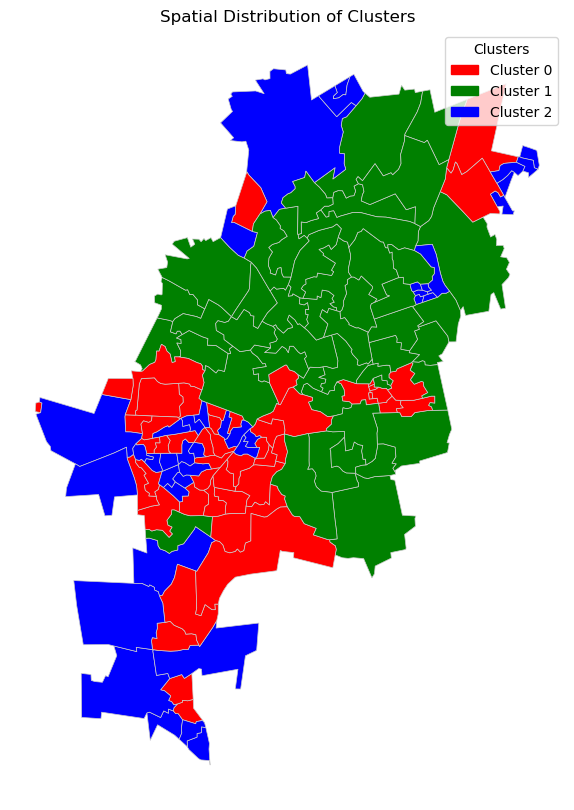

In [46]:
# Map clusters
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.plot(
    column='Cluster',
    categorical=True,
    cmap=ListedColormap([cluster_colors[i] for i in cluster_colors.keys()]),
    legend=True,
    linewidth=0.5,
    ax=ax,
    edgecolor='0.8'
)

# Customize legend
handles = [plt.Rectangle((0,0),1,1, color=cluster_colors[i]) for i in cluster_colors]
labels = [f'Cluster {i}' for i in cluster_colors.keys()]
ax.legend(handles, labels, title='Clusters')

plt.title('Spatial Distribution of Clusters')
ax.set_axis_off()
plt.show()


In [47]:
# Wards with high Climate_PC1 and low SocioEcon_PC1 (e.g., above 75th percentile for Climate_PC1 and below 25th percentile for SocioEcon_PC1)
climate_75th = gdf_clean['Climate_PC1'].quantile(0.75)
socioecon_25th = gdf_clean['SocioEcon_PC1'].quantile(0.25)

# Filter wards
high_climate_low_socioecon = gdf_clean[
    (gdf_clean['Climate_PC1'] >= climate_75th) &
    (gdf_clean['SocioEcon_PC1'] <= socioecon_25th)
]

# Display selected wards
print("Wards with High Climate Vulnerability and Low Socio-Economic Vulnerability:")
print(high_climate_low_socioecon[['WardID_', 'Climate_PC1', 'SocioEcon_PC1', 'HVI_weighted_standardized']])


Wards with High Climate Vulnerability and Low Socio-Economic Vulnerability:
      WardID_  Climate_PC1  SocioEcon_PC1  HVI_weighted_standardized
1    79800001     1.099797      -2.347112                   0.328713
5    79800005     1.957652      -2.041359                   0.251957
6    79800006     1.306737      -3.112988                   0.176885
15   79800015     2.176616      -2.684147                   0.198324
16   79800016     0.982994      -2.004423                   0.440725
53   79800053     1.088688      -2.610411                   0.275154
75   79800075     2.066264      -2.293384                   0.190037
77   79800077     2.438844      -2.092031                   0.161720
78   79800079     2.258914      -2.256262                   0.130058
79   79800080     1.508655      -2.336872                   0.165121
94   79800095     1.698551      -2.286235                   0.066151
106  79800107     3.504402      -2.594989                   0.050775
115  79800116     4.391637 

In [48]:
# Select variables to display
variables_of_interest = climate_vars + socio_econ_vars

# Display data for selected wards
for idx, row in high_climate_low_socioecon.iterrows():
    print(f"\nWard ID: {row['WardID_']}")
    print(row[variables_of_interest])



Ward ID: 79800001
UTFVI                                    -0.02989
LST                                      29.03614
NDVI                                     0.127435
NDBI__mean                               0.359614
Crowded dwellings                           13.43
No piped water                               1.63
Using public healthcare facilities          83.82
Poor health status                           5.64
Failed to find healthcare when needed       10.54
No medical insurance                        83.44
Household hunger risk                       50.33
Benefiting from school feeding scheme       58.62
diabetes_p                               0.000385
heart_dise                               0.001154
hypertensi                               0.004231
hiv_prop                                 0.001923
tb_prop                                       0.0
covid_prop                               0.000385
60_plus_pr                               0.000385
Name: 1, dtype: object

Ward ID

In [49]:
# Prepare independent variables (socio-economic variables)
X = gdf_clean[socio_econ_vars]

# Standardize variables
X_scaled = scaler.fit_transform(X)

# Dependent variable (Climate_PC1)
y = gdf_clean['Climate_PC1']

# Add constant term
X_const = sm.add_constant(X_scaled)

# Fit OLS regression model
model = sm.OLS(y, X_const).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            Climate_PC1   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     5.665
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           1.28e-08
Time:                        13:53:13   Log-Likelihood:                -216.21
No. Observations:                 135   AIC:                             464.4
Df Residuals:                     119   BIC:                             510.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.776e-17      0.110  -2.52e-16      1.0

In [50]:
# For simplicity, select key variables
key_vars = ['LST', 'NDVI', 'Household hunger risk', 'No medical insurance']

# Prepare data
interaction_data = gdf_clean[key_vars]

# Create interaction terms
interaction_data['LST_x_Hunger'] = interaction_data['LST'] * interaction_data['Household hunger risk']
interaction_data['NDVI_x_NoInsurance'] = interaction_data['NDVI'] * interaction_data['No medical insurance']

# Dependent variable
y = gdf_clean['HVI_weighted_standardized']

# Independent variables
X = interaction_data

# Standardize variables
X_scaled = scaler.fit_transform(X)

# Add constant term
X_const = sm.add_constant(X_scaled)

# Fit OLS regression model
model = sm.OLS(y, X_const).fit()

# Print summary
print(model.summary())


                                OLS Regression Results                               
Dep. Variable:     HVI_weighted_standardized   R-squared:                       0.917
Model:                                   OLS   Adj. R-squared:                  0.913
Method:                        Least Squares   F-statistic:                     235.4
Date:                       Wed, 02 Oct 2024   Prob (F-statistic):           1.28e-66
Time:                               13:53:44   Log-Likelihood:                 176.25
No. Observations:                        135   AIC:                            -338.5
Df Residuals:                            128   BIC:                            -318.2
Df Model:                                  6                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

C:\Users\CraigParker\AppData\Local\Temp\ipykernel_32324\1670128401.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interaction_data['LST_x_Hunger'] = interaction_data['LST'] * interaction_data['Household hunger risk']
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_32324\1670128401.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interaction_data['NDVI_x_NoInsurance'] = interaction_data['NDVI'] * interaction_data['No medical insurance']


In [51]:
import geopandas as gpd
import numpy as np

# Project your GeoDataFrame to a suitable projected CRS (e.g., UTM)
gdf_clean = gdf_clean.to_crs(epsg=32735)  # Example EPSG code for UTM Zone 35S

# Extract the coordinates
gdf_clean['coord_x'] = gdf_clean.geometry.centroid.x
gdf_clean['coord_y'] = gdf_clean.geometry.centroid.y


In [52]:
# Select variables for GWPCA
variables = [
    'Crowded dwellings', 'No piped water', 'Using public healthcare facilities', 'Poor health status',
    'Failed to find healthcare when needed', 'No medical insurance', 'Household hunger risk',
    'Benefiting from school feeding scheme', 'UTFVI', 'LST', 'NDVI', 'NDBI__mean', 'concern_he',
    'cancer_pro', 'diabetes_p', 'pneumonia_', 'heart_dise', 'hypertensi', 'hiv_prop', 'tb_prop',
    'covid_prop', '60_plus_pr'
]

# Extract variable matrix and standardize
from sklearn.preprocessing import StandardScaler

X = gdf_clean[variables].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Extract coordinates
coords = gdf_clean[['coord_x', 'coord_y']].values


In [53]:
from mgwr.gwr import Sel_BW

# Bandwidth selection
selector = Sel_BW(coords, X_scaled)
bandwidth = selector.search(bw_min=2)
print(f"Optimal bandwidth: {bandwidth}")


ImportError: cannot import name 'Sel_BW' from 'mgwr.gwr' (c:\Users\craigparker\Anaconda3\Lib\site-packages\mgwr\gwr.py)